In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

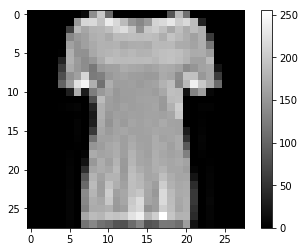

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

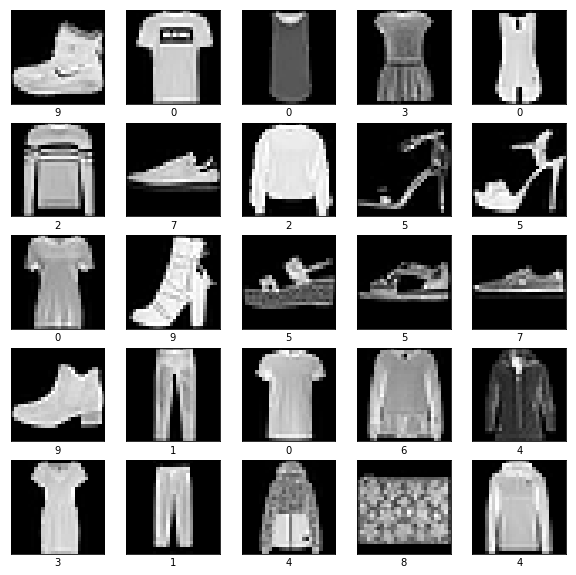

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Choosing three classes from dataset
We've choosed
* 0	T-shirt/top
* 1	Trouser
* 4	Coat

First we're going to filter train set

In [7]:
def filteringClasses(images, labels):
    condition = (labels == 0) + (labels == 1) + (labels == 4)
    return (images[condition],labels[condition])

In [55]:
images_filtered_train,labels_filtered_train=filteringClasses(train_images, train_labels)
images_filtered_test,labels_filtered_test=filteringClasses(test_images, test_labels)

In [9]:
img_reshaped_traing = images_filtered_train.reshape(18000, 784)
img_reshaped_test = images_filtered_test.reshape(3000, 784)

We are going to create a dictionary to associate numerical values with label names

In [58]:
value_label = {0:"T-shirt",1:"Trouser",4:"Coat"}

Last in preprocessing, we are going to encode y with one_hot_encoding

In [11]:
with tf.Session() as session:
    y_real_train = session.run(tf.one_hot(labels_filtered_train,3))
    y_real_test = session.run(tf.one_hot(labels_filtered_test,3))

Now, it's time to create the graph

In [12]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, [None, 784]) 
    y = tf.placeholder(tf.float32, [None, 3]) 
    learning_rate = tf.placeholder("float")
    W = tf.Variable(tf.random_normal((784,3)), name = "W", dtype="float") #
    b = tf.Variable(tf.random_normal((1,3)), name = "b", dtype="float") # 

    with tf.name_scope("Model"):
        y_hat = tf.nn.softmax(tf.matmul(x, W) + b, name="Model")
    with tf.name_scope("Cost"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( 
                            labels=y, logits=y_hat))
        cross_summary = tf.summary.scalar('Cost', cross_entropy)
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy) 
    with tf.name_scope("Accuracy"):
        correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)

    summaries = tf.summary.merge_all()
    init = tf.global_variables_initializer()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



With the graph defined it's time to make the training process

In [15]:

def training(lr,batch_size,epochs,x_values):
    tf.reset_default_graph()
    number_batches = int(len(y_real_train)/batch_size)
    with tf.Session(graph=g) as sess: 

        writer = tf.summary.FileWriter('./graphs', sess.graph)
        sess.run(init) 
        for epoch in range(epochs): 
            for batch in range(number_batches):
                init_value = batch*(batch_size)
                #print("from: ",init_value," to: ",(init_value+batch_size-1))
                X = x_values[init_value:init_value+batch_size-1]
                Y = y_real_train[init_value:init_value+batch_size-1]
                sess.run(train_step, feed_dict = {x : X, y : Y,learning_rate:lr}) 

            if (epoch + 1) % 10 == 0: 
                co,we,inte,acc,summ= sess.run([cross_entropy,W,b,accuracy,summaries],feed_dict = {x : X, y : Y,learning_rate:lr}) 
                writer.add_summary(summ, epoch+1)
                print("Epoch", (epoch + 1), ": cost =", co, "b =", inte," accuracy: ",acc) 
                W_result = we
                b_result = inte
                
        
        writer.close()
    return (W_result, b_result)

### Tensorboard graph visual representation

<img src="./grafo.PNG">

###  Training without normalization

In [16]:
training(0.001,32,50,img_reshaped_traing)

Epoch 10 : cost = 1.0509787 b = [[-1.3639665 -1.4015685  0.3696353]]  accuracy:  0.0
Epoch 20 : cost = 0.7929141 b = [[-1.3639487 -1.4013618  0.3694098]]  accuracy:  0.2580645
Epoch 30 : cost = 0.69613993 b = [[-1.3639419  -1.4012061   0.36924696]]  accuracy:  0.3548387
Epoch 40 : cost = 0.69613993 b = [[-1.3639419  -1.4011668   0.36920777]]  accuracy:  0.3548387
Epoch 50 : cost = 0.69613993 b = [[-1.3639419 -1.4011551  0.3691959]]  accuracy:  0.3548387


(array([[-1.1714731 ,  1.6874568 ,  1.3514029 ],
        [-0.41658828,  1.35566   ,  1.0381285 ],
        [-1.5081272 ,  0.02472769,  0.5326337 ],
        ...,
        [ 0.00333443,  0.54599315, -0.01942497],
        [-0.9858969 , -0.74575984, -1.0598049 ],
        [ 2.0602868 , -1.7254075 ,  0.35553914]], dtype=float32),
 array([[-1.3639419, -1.4011551,  0.3691959]], dtype=float32))

### Training with normalization

In [61]:
(W_values,b_values)=training(0.01,32,50,img_reshaped_traing/255)

Epoch 10 : cost = 0.40585124 b = [[-0.10044213  1.2468444  -0.13742419]]  accuracy:  0.9354839
Epoch 20 : cost = 0.40544873 b = [[-0.04413515  1.21795    -0.16483241]]  accuracy:  0.9354839
Epoch 30 : cost = 0.40517965 b = [[ 0.0050419   1.1848124  -0.18087246]]  accuracy:  0.9354839
Epoch 40 : cost = 0.4047939 b = [[ 0.05169835  1.150867   -0.19358109]]  accuracy:  0.9354839
Epoch 50 : cost = 0.40423113 b = [[ 0.09688986  1.1167344  -0.2046353 ]]  accuracy:  0.9354839


### Results for data without normalization

<img src="./accuracy_cost.PNG">

### Results for data with normalization

<img src="./accuracy_cost_normalized.PNG">

In [69]:
def predictionImg(image,label):
    print("pretend ",value_label[label])
    img = image.reshape(1,784)
    x = (np.matmul(img,W_values)+b_values)
    prediction = np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))
    print("probabilistic prediction ",prediction)
    n_feature = np.argmax(prediction)
    plt.imshow(image, cmap='gray')
    plt.xlabel(value_label[n_feature])

pretend  Trouser
probabilistic prediction  [[0. 1. 0.]]


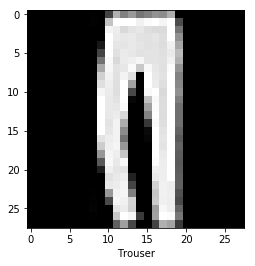

In [70]:
predictionImg(images_filtered_test[0],labels_filtered_test[0])


pretend  Trouser
probabilistic prediction  [[0. 1. 0.]]


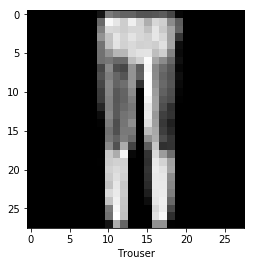

In [71]:
predictionImg(images_filtered_test[1],labels_filtered_test[1])

pretend  Trouser
probabilistic prediction  [[0. 1. 0.]]


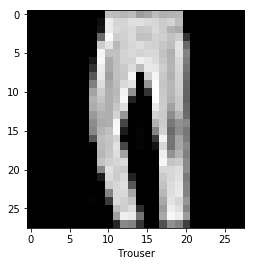

In [72]:
predictionImg(images_filtered_test[2],labels_filtered_test[2])

pretend  Coat
probabilistic prediction  [[1. 0. 0.]]


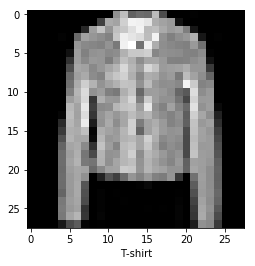

In [73]:
predictionImg(images_filtered_test[4],labels_filtered_test[4])

pretend  Coat
probabilistic prediction  [[1. 0. 0.]]


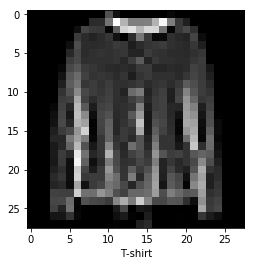

In [75]:
predictionImg(images_filtered_test[10],labels_filtered_test[10])

## Conclusions
* Gradiend descend converge faster when the data is normalized
* The model is not good whit